In [13]:
import numpy as np
import torch
from Code.Torsh.TorchMacsumAggregationLearning import *
import torch.nn.functional as F
from sklearn.metrics import r2_score
from tqdm import trange
from Code.Torsh.NetowrkMacsum import MacsumNetWithActivation

In [2]:
N_SAMPLES, N_FEATURES = 5000, 5

In [52]:
def generate_friedman1_data(n_samples: int, n_features: int, noise_std: float = 0.1):
    """
    Génère des données basées sur la fonction de test de Friedman #1.
    
    Args:
        n_samples: Nombre d'échantillons à générer.
        n_features: Nombre total de features. Doit être >= 5.
        noise_std: Écart-type du bruit gaussien ajouté à la sortie.
                   Mettre à 0 pour avoir des données parfaites (sans bruit).
    
    Returns:
        Tuple (X, y) où X.shape=(n_samples, n_features) et y.shape=(n_samples,)
    """
    if n_features < 5:
        raise ValueError("n_features must be at least 5 for Friedman #1 function.")
        
    X = np.random.rand(n_samples, n_features) * 10
    
    # Calculer la sortie Y en utilisant la formule
    # Seules les 5 premières colonnes de X sont utilisées
    term1 = 10 * np.sin(np.pi * X[:, 0] * X[:, 1])
    term2 = 20 * (X[:, 2] - 0.5)**2
    term3 = 10 * X[:, 3]
    term4 = 5 * X[:, 4]
    
    y_true = term1 + term2 + term3 + term4
    
    # Ajouter du bruit gaussien si nécessaire
    if noise_std > 0:
        noise = np.random.normal(0, noise_std, n_samples)
        y_noisy = y_true + noise
        return X, y_noisy
    else:
        return X, y_true

In [53]:
X, Y = generate_friedman1_data(N_SAMPLES, N_FEATURES, noise_std=0.0)
X_test, Y_test = generate_friedman1_data(500, N_FEATURES, noise_std=0.0)

In [54]:
class SimpleMLP(nn.Module):
    def __init__(self, in_features, hidden_layer1=32, hidden_layer2=16, out_features=1):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_layer1)
        self.layer2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.output_layer = nn.Linear(hidden_layer2, out_features)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x
    
def train_mlp_from_numpy_no_norm(
    X_train_np: np.ndarray, 
    Y_train_np: np.ndarray, 
    X_eval_np: np.ndarray, 
    Y_eval_np: np.ndarray, 
    learning_rate: float = 1e-3, 
    n_epochs: int = 200, 
    batch_size: int = 64, 
    weight_decay: float = 1e-4,
    print_every: int = 20
) -> tuple[nn.Module, float]:
    """
    Entraîne un MLP à partir de données NumPy, SANS normalisation.

    Args:
        X_train_np (np.ndarray): Données d'entraînement (features).
        Y_train_np (np.ndarray): Données d'entraînement (cibles).
        X_eval_np (np.ndarray): Données d'évaluation (features).
        Y_eval_np (np.ndarray): Données d'évaluation (cibles).
        ... autres hyperparamètres ...

    Returns:
        tuple[nn.Module, float]: 
            - Le modèle entraîné.
            - Le score R² final sur les données d'évaluation.
    """
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for MLP: {DEVICE}")
    
    # 1. Normalisation des données
    # --- BLOC DE NORMALISATION SUPPRIMÉ ---
    print("WARNING: Training without data normalization. This may lead to poor performance or instability.")

    # 2. Conversion en tenseurs PyTorch
    # Les données NumPy sont utilisées directement.
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train_np, dtype=torch.float32)
    X_eval_t = torch.tensor(X_eval_np, dtype=torch.float32)
    Y_eval_t = torch.tensor(Y_eval_np, dtype=torch.float32)

    # 3. Création du modèle et des DataLoaders
    n_features = X_train_np.shape[1]
    model = SimpleMLP(in_features=n_features).to(DEVICE)
    print("\nMLP Model Architecture:")
    print(model)

    train_dataset = TensorDataset(X_train_t, Y_train_t)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 4. Définir l'optimiseur et la fonction de coût
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    print("\nStarting MLP training...")
    for epoch in trange(1, n_epochs + 1, desc="MLP Training"):
        model.train()
        for X_batch, Y_batch in train_dataloader:
            X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
            
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, Y_batch)

            # Vérification de la stabilité de la perte
            if torch.isnan(loss):
                print("\nERROR: Loss is NaN. Training stopped. Try a smaller learning rate.")
                return model, -float('inf')
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Évaluation périodique
        if epoch % print_every == 0 or epoch == n_epochs:
            model.eval()
            with torch.no_grad():
                y_pred_eval = model(X_eval_t.to(DEVICE)).squeeze()
                eval_loss = loss_fn(y_pred_eval, Y_eval_t.to(DEVICE))
                r2 = r2_score(Y_eval_np, y_pred_eval.cpu().numpy())
                tqdm.write(f"Epoch {epoch}/{n_epochs} | Eval MSE: {eval_loss.item():.4f} | Eval R²: {r2:.4f}")
    
    print("\nTraining finished.")
    
    # 5. Évaluation finale
    final_r2 = r2 # La dernière valeur calculée
    print(f"\nMLP Final Evaluation Results (without normalization):")
    print(f"  - Final Eval R² Score: {final_r2:.4f}")
    
    return model, final_r2

In [55]:
mlp = SimpleMLP(in_features=N_FEATURES)
X_train_t = torch.tensor(X, dtype=torch.float32)
Y_train_t = torch.tensor(Y, dtype=torch.float32)
X_eval_t = torch.tensor(X_test, dtype=torch.float32)
Y_eval_t = torch.tensor(Y_test, dtype=torch.float32)
trained_mlp, r2_baseline = train_mlp(
        model=mlp,
        X_train=X_train_t,
        Y_train=Y_train_t,
        X_eval=X_eval_t,
        Y_eval=Y_eval_t,
        n_epochs=200, # 200 époques suffisent souvent pour un MLP
        learning_rate=1e-3,
        weight_decay=1e-4
    )

Starting MLP training...


MLP Training: 100%|██████████| 200/200 [00:07<00:00, 27.65it/s]


Training finished.
MLP Evaluation Results:
  - Final Eval MSE Loss: 72.9506
  - Final Eval R² Score: 0.9998


In [66]:
model = MacsumSigmoidTorch(N_FEATURES,alpha=2,gamma = 0.8,k_sigmoid=0.1)
model.fit_adam(X,Y,X,Y,learning_rate=1e-3,epsilon_conv=1e-6,n_epochs = 5000,beta1=0.8,beta2=0.99,batch_size=256)

Starting PyTorch Adam training (MacsumSigmoidTorch with Manual Gradient for Phi)...


Adam Training (MacsumSigmoidTorch Manual Grad): 100%|██████████| 5000/5000 [01:59<00:00, 41.99it/s]

Training finished for MacsumSigmoidTorch (max epochs reached or converged earlier via manual grad fit_adam).


array([24.30231322, 24.30276089, 99.69708209, 24.30249046, 24.30291322])

In [ ]:
model = MacsumNetWithActivation([N_FEATURES,32,16,1],model_class= MacsumSigmoidTorch,activation_fn=F.leaky_relu,alpha=3,gamma = 0.8,k_sigmoid=0.1)
model.fit_autograd(X,Y,X,Y,learning_rate=5e-4,epsilon_conv=1e-6,n_epochs = 500,beta1=0.8,beta2=0.99,batch_size=256)

Création d'un MacsumNet avec la fonction d'activation: leaky_relu
Starting PyTorch Autograd training for MacsumNet...


Autograd Training (MacsumNet):   1%|          | 9/1000 [00:04<08:37,  1.92it/s]


KeyboardInterrupt: 

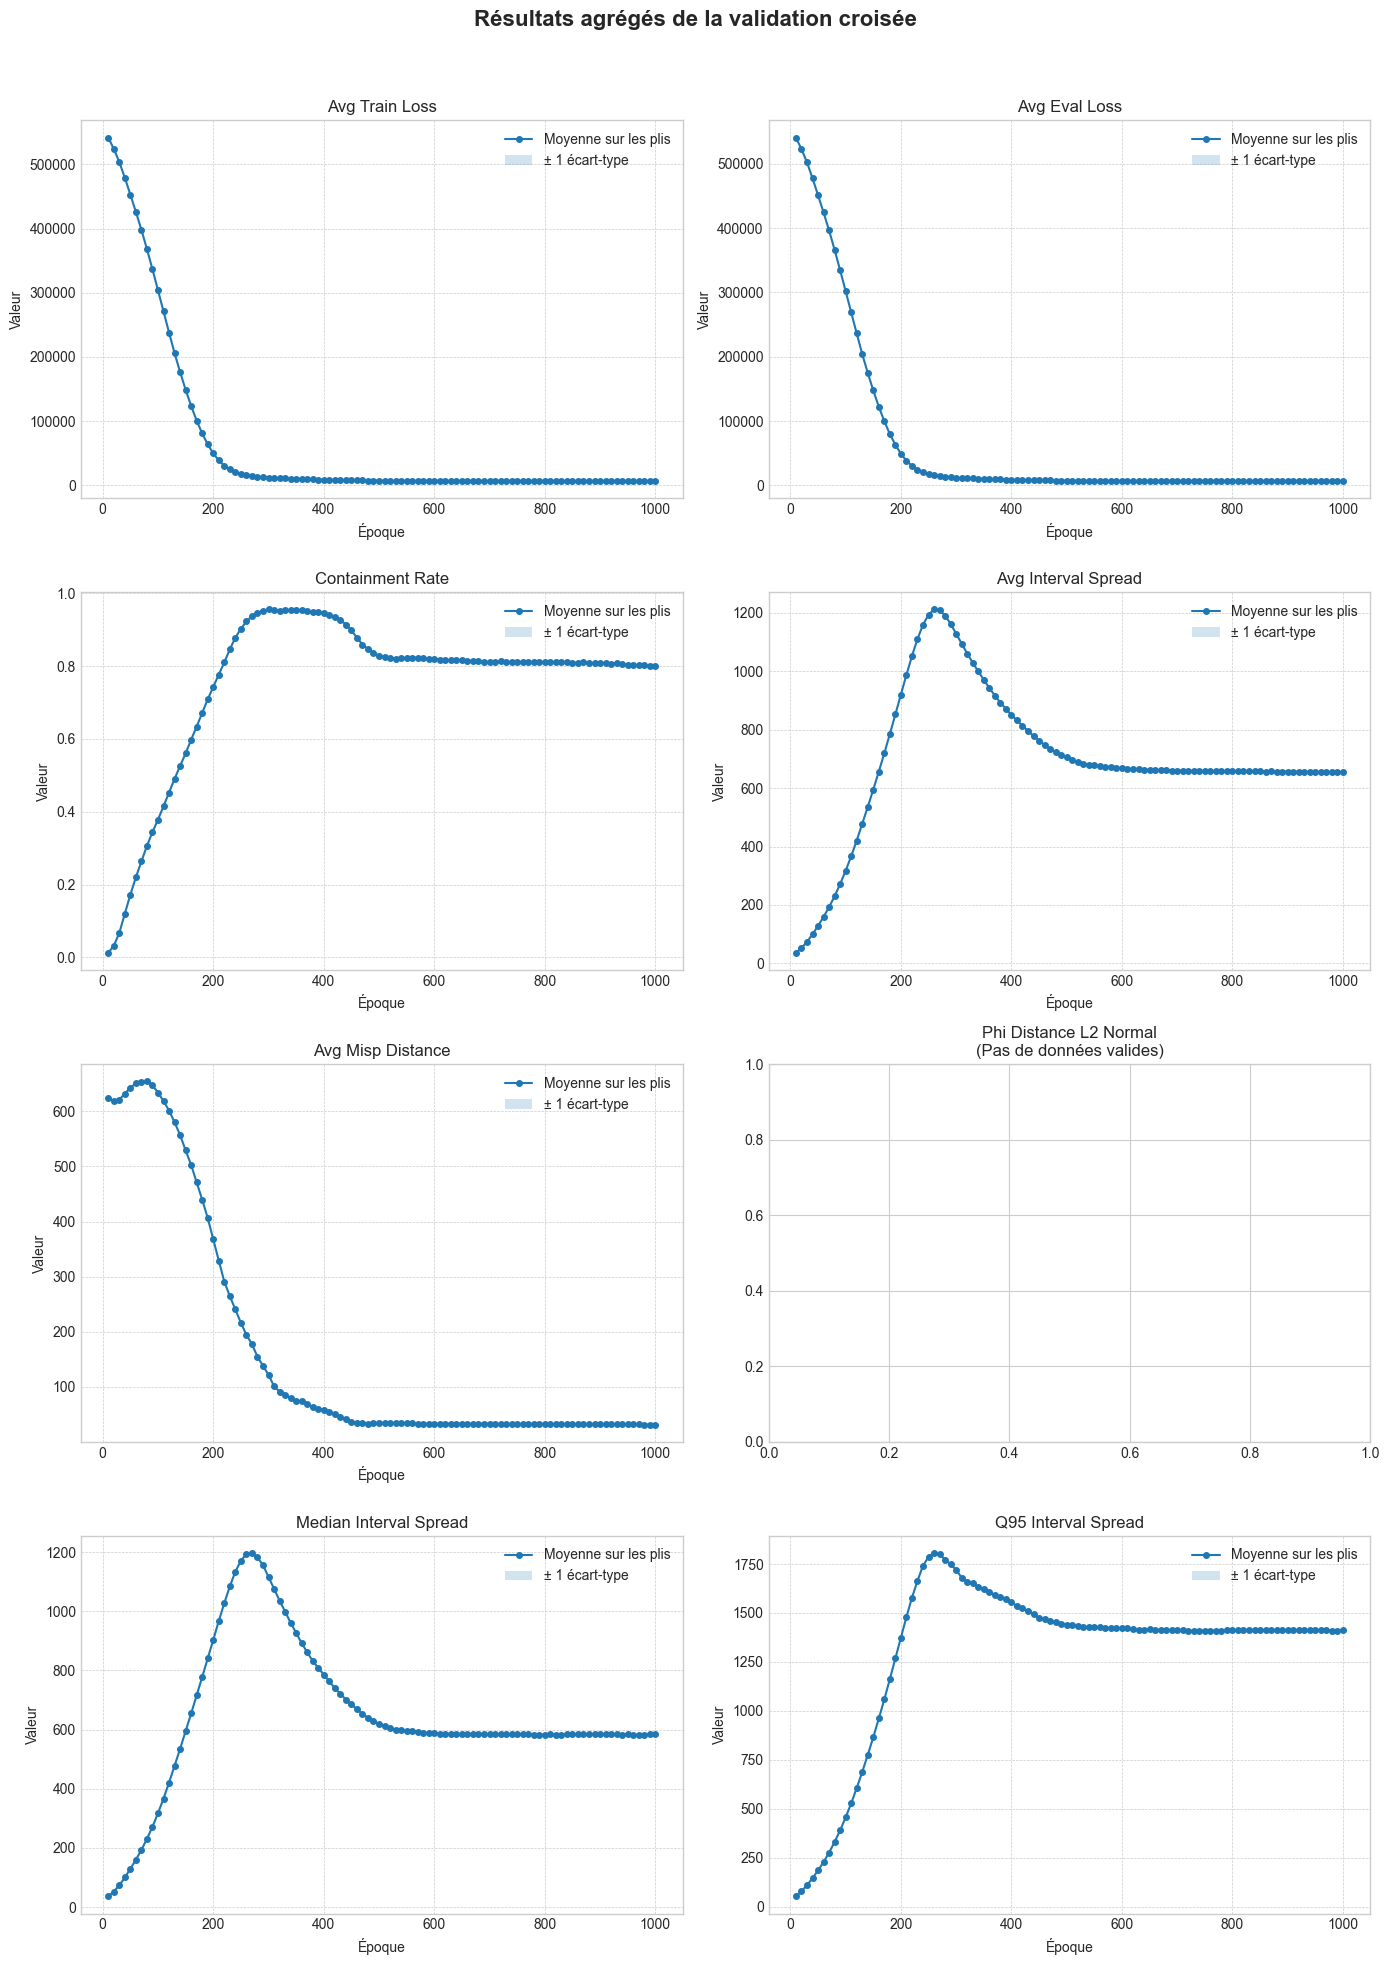

In [76]:
plot_metrics_complet([model.history,model.history])

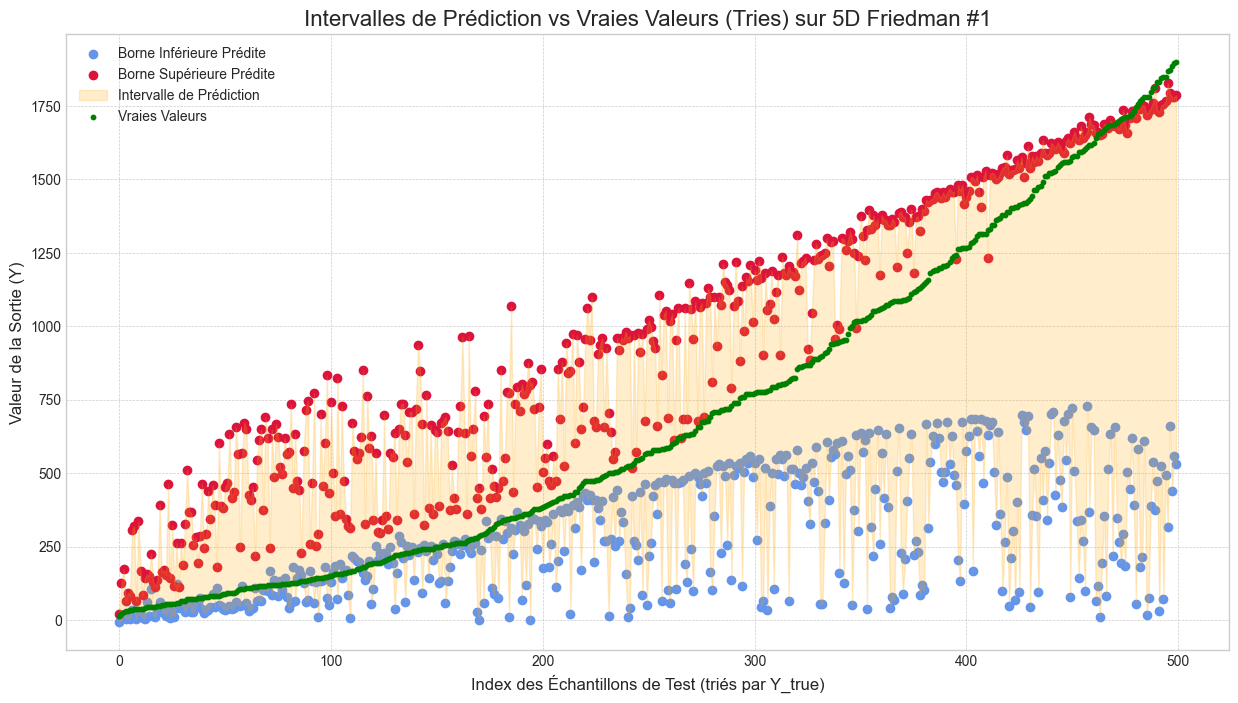

Coefficient de Détermination (R²) : 0.6971
Taux de Contenance de l'intervalle : 0.8260
Largeur Moyenne de l'intervalle : 668.9258


In [77]:
model.eval() # Passer en mode évaluation

# Prédictions sur l'ensemble de test
with torch.no_grad():
    X_test_t = torch.tensor(X_test, device=DEVICE, dtype=torch.float64)
    y_lower_pred, y_upper_pred = model(X_test_t)
    
    y_lower_pred_np = y_lower_pred.cpu().numpy()
    y_upper_pred_np = y_upper_pred.cpu().numpy()

# --- Préparation pour le graphique ---

# 1. Obtenir les indices qui trieraient les vraies valeurs
#    Cela nous permettra de tracer les points dans un ordre croissant de Y.
sort_indices = np.argsort(Y_test)

# 2. Trier toutes nos données (vraies et prédites) en utilisant ces indices
Y_test_true_sorted = Y_test[sort_indices]
y_lower_pred_sorted = y_lower_pred_np[sort_indices]
y_upper_pred_sorted = y_upper_pred_np[sort_indices]

# Créer un index simple pour l'axe des x (de 0 au nombre d'échantillons)
x_axis_index = np.arange(len(Y_test_true_sorted))


# --- Création du graphique ---
plt.figure(figsize=(15, 8))

# 1. Tracer les bornes supérieure et inférieure
plt.scatter(x_axis_index, y_lower_pred_sorted, color='cornflowerblue', label='Borne Inférieure Prédite')
plt.scatter(x_axis_index, y_upper_pred_sorted, color='crimson', label='Borne Supérieure Prédite')

# 2. Remplir la zone entre les bornes pour visualiser l'intervalle de confiance
plt.fill_between(
    x_axis_index, 
    y_lower_pred_sorted, 
    y_upper_pred_sorted, 
    color='orange', 
    alpha=0.2, 
    label='Intervalle de Prédiction'
)

# 3. Tracer les vraies valeurs par-dessus, en vert
plt.scatter(
    x_axis_index, 
    Y_test_true_sorted, 
    color='green', 
    s=10, # 's' est la taille des points
    label='Vraies Valeurs',
    zorder=5 # Mettre les points verts au premier plan
)


# --- Mise en forme du graphique ---
plt.title(f"Intervalles de Prédiction vs Vraies Valeurs (Tries) sur {N_FEATURES}D Friedman #1", fontsize=16)
plt.xlabel("Index des Échantillons de Test (triés par Y_true)", fontsize=12)
plt.ylabel("Valeur de la Sortie (Y)", fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# --- Ré-afficher les métriques quantitatives ---

y_mid_pred_np = (y_lower_pred_np + y_upper_pred_np) / 2
r2 = r2_score(Y_test, y_mid_pred_np)
print(f"Coefficient de Détermination (R²) : {r2:.4f}")

containment = np.mean((Y_test >= y_lower_pred_np) & (Y_test <= y_upper_pred_np))
avg_spread = np.mean(y_upper_pred_np - y_lower_pred_np)
print(f"Taux de Contenance de l'intervalle : {containment:.4f}")
print(f"Largeur Moyenne de l'intervalle : {avg_spread:.4f}")

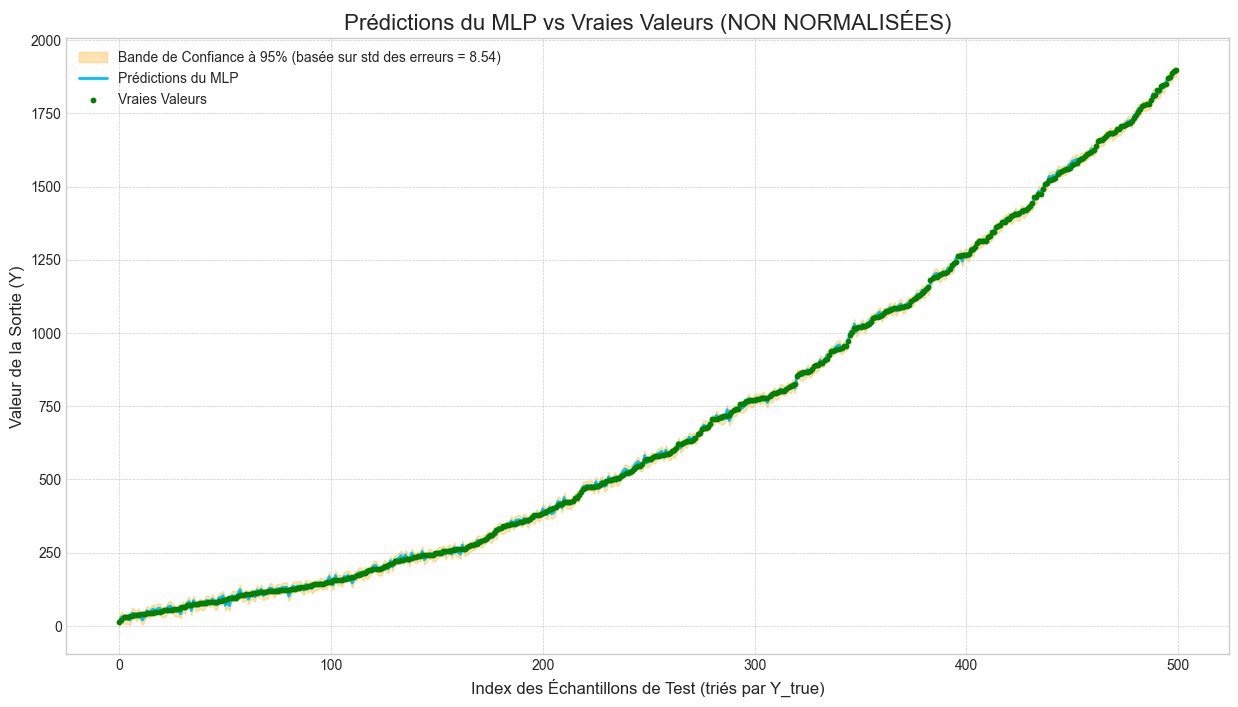

Résultats du MLP sur l'ensemble de test (sans normalisation):
  - Coefficient de Détermination (R²) : 0.9998
  - Erreur Quadratique Moyenne (MSE) : 72.9506


In [59]:
# Mettre le modèle en mode évaluation
trained_mlp.eval()

# Prédictions sur l'ensemble de test
with torch.no_grad():
    # Convertir les données NumPy brutes en tenseur
    X_eval_t = torch.tensor(X_test, device=DEVICE, dtype=torch.float32)
    
    # Obtenir les prédictions
    y_pred_mlp_t = trained_mlp(X_eval_t)
    
    # Convertir les prédictions en tableau NumPy
    y_pred_mlp_np = y_pred_mlp_t.squeeze().cpu().numpy()

# Calculer les résidus (erreurs de prédiction)
residuals = Y_test- y_pred_mlp_np
# Calculer l'écart-type des résidus. C'est une mesure de l'erreur "typique" du modèle.
error_std = np.std(residuals)

# --- Préparation pour le graphique ---

# 1. Obtenir les indices qui trieraient les vraies valeurs
sort_indices = np.argsort(Y_test)

# 2. Trier toutes nos données en utilisant ces indices
Y_eval_true_sorted = Y_test[sort_indices]
y_pred_mlp_sorted = y_pred_mlp_np[sort_indices]

# Créer un index simple pour l'axe des x
x_axis_index = np.arange(len(Y_eval_true_sorted))

# --- Création du graphique ---
plt.figure(figsize=(15, 8))

# 1. Tracer l'intervalle de confiance (bande d'erreur) autour des prédictions
plt.fill_between(
    x_axis_index,
    y_pred_mlp_sorted - 1.96 * error_std,
    y_pred_mlp_sorted + 1.96 * error_std,
    color='orange',
    alpha=0.3, # Rendre la bande semi-transparente
    label=f'Bande de Confiance à 95% (basée sur std des erreurs = {error_std:.2f})'
)

# 2. Tracer la ligne de prédiction du MLP
plt.plot(
    x_axis_index, 
    y_pred_mlp_sorted, 
    color='deepskyblue', 
    linewidth=2,
    label='Prédictions du MLP',
    zorder=4
)

# 3. Tracer les vraies valeurs par-dessus, en vert
plt.scatter(
    x_axis_index, 
    Y_eval_true_sorted, 
    color='green', 
    s=10, 
    label='Vraies Valeurs',
    zorder=5
)

# --- Mise en forme du graphique ---
N_FEATURES_in_data =X_test.shape[1]
plt.title(f"Prédictions du MLP vs Vraies Valeurs (NON NORMALISÉES)", fontsize=16)
plt.xlabel("Index des Échantillons de Test (triés par Y_true)", fontsize=12)
plt.ylabel("Valeur de la Sortie (Y)", fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# --- Ré-afficher les métriques quantitatives ---

r2 = r2_score(Y_test, y_pred_mlp_np)
mse = np.mean(residuals**2)
print(f"Résultats du MLP sur l'ensemble de test (sans normalisation):")
print(f"  - Coefficient de Détermination (R²) : {r2:.4f}")
print(f"  - Erreur Quadratique Moyenne (MSE) : {mse:.4f}")